In [221]:
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from random import randint
import glob
import os
import random
import datetime

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

from scipy import misc
from scipy import ndimage
from skimage import feature

%matplotlib inline

In [222]:
class CamaraModelDataset(Dataset):

    def __init__(self, path2data, transforms=None, is_train = False, is_test=False):
        
        self.transform = transforms 
        
        self.X= []
        self.y = []
        count = 0
        labels = {}
        for subdir, dirs, files in os.walk(path):
            if subdir.split('/')[-1] != '':
                labels[count] = subdir.split('/')[-1]
                path_folder = os.path.join(subdir, '*.jpg')
                files = glob.glob(path_folder) 
                self.X.extend(files)
                self.y.extend(np.full((1, len(files)), count, dtype=int)[0])
                
                count = count + 1
                
        self.labels = labels
            
    def __getitem__(self, index):
        
        path = self.X[index]
        label = self.y[index]

        with open(path, 'rb') as f:
            flbase = os.path.basename(path)
            
            with Image.open(f) as img:
                 image = img.convert('RGB')
                    
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.X)

In [223]:
class RGB2Gray(object):
    
    def __call__(self, image):
        image = np.array(image)
        return np.dot(image[...,:3], [0.299, 0.587, 0.114]).astype(int)

In [224]:
class NormalizeGrayImage(object):
    
    def __call__(self, image):
        return image/255.

In [225]:
eps=1e-7
numPoints = 24
radius = 3

In [226]:
class LocalBinaryPatterns(object):

    def __call__(self, image):

        lbp = feature.local_binary_pattern(image, numPoints,
                    radius, method="uniform")

        return lbp

In [227]:
class ProbabilityDistribution(object):
    
    def __call__(self, image):


        # return the histogram of Local Binary Patterns
        (hist, _) = np.histogram(image,
            bins=np.arange(0, numPoints + 3),
            range=(0, numPoints + 2))

        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        
        return hist

In [228]:
img_width = img_height=128
nb_channels = 1

In [229]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

In [230]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_width, img_height)),
        RGB2Gray(),
        #LocalBinaryPatterns(),
        NormalizeGrayImage()
    ])
}

In [231]:
path = 'data/flowers/'

In [232]:
dsets = {'train': CamaraModelDataset(path, transforms=data_transforms['train'],  is_train = True),
         'valid': CamaraModelDataset(path, transforms=data_transforms['train'],  is_train = True),
        }

In [233]:
random_seed = 3
shuffle = True
valid_size = 0.2
batch_size = 128

In [234]:
num_train = len(dsets['train'])
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [235]:
dloader ={'train': torch.utils.data.DataLoader(dsets['train'], batch_size=batch_size, sampler=train_sampler),
         'valid': torch.utils.data.DataLoader(dsets['valid'], batch_size=batch_size, sampler=valid_sampler)
         } 

In [236]:
labels = dsets['train'].labels
print('Labels of the dataset: {}'.format(labels))

Labels of the dataset: {0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}


In [237]:
def CamaraPhotos(dsets, labels):
    
    rand_img = random.randrange(0, len(dsets))
    img, y = dsets[rand_img]
    img = img.numpy()
    img = img.transpose((1, 2, 0))  # Channel Last
    plt.imshow(img)
    
    plt.title('Label: {}'.format(labels[int(y)]))

    plt.axis('off')

In [238]:
'''
plt.figure(figsize=(20,5))
for i in range(0, 3):
    plt.subplot(1,3,i+1)

    CamaraPhotos(dsets['train'], labels)
'''

"\nplt.figure(figsize=(20,5))\nfor i in range(0, 3):\n    plt.subplot(1,3,i+1)\n\n    CamaraPhotos(dsets['train'], labels)\n"

In [239]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [240]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, input_size*2)
        self.at1 = nn.ReLU()
        self.fc2 = nn.Linear(input_size*2, num_classes)

    def forward(self, x):
        x = x.view(-1, input_size)
        x = self.fc1(x)
        x = self.at1(x)
        x = self.fc2(x)
        return x

In [241]:
input_size = nb_channels*img_width*img_height
#input_size = numPoints + 2
num_classes = len(dsets['train'].labels)
print('Input size: {}, Classes: {}'.format(input_size, num_classes))

Input size: 16384, Classes: 5


In [242]:
model = NeuralNetwork(input_size, num_classes)

In [243]:
n_epochs = 10
learningRate = 0.001

In [244]:
#https://discuss.pytorch.org/t/simple-l2-regularization/139/8
criterion = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [ ]:
start_time = datetime.datetime.now()

for epoch in range(n_epochs):
    i0 = 0
    for i, (features, labels) in enumerate(dloader['train']):
    
        features = Variable(features.view(-1, nb_channels*img_width*img_height))
        #features = Variable(features)
        labels = Variable(labels)
        features = features.float()
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(features)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        i0+=1
        print('\rProcessing Batches: {}/{}'.format(i0, len(dloader['train'])), end='')

    print ('\nEpoch: [%d/%d], Loss: %.4f' 
           % (epoch+1, n_epochs, loss.data[0]))
    
print('Execution time {0:.2f} s'.format((datetime.datetime.now() - start_time).total_seconds()))

Processing Batches: 28/28
Epoch: [1/10], Loss: 1.4955
Processing Batches: 28/28
Epoch: [2/10], Loss: 1.6002
Processing Batches: 11/28

### Evaluate the model

In [195]:
def predict(dset_loaders, model, use_gpu=False):

    predictions = []
    labels_lst = []
    ii_n = len(dset_loaders)
    start_time = datetime.datetime.now()

    for i, (inputs, labels) in enumerate(dset_loaders):
        
        
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        inputs = Variable(inputs.view(-1, nb_channels*img_width*img_height)).float()
        #inputs = Variable(inputs).float()
        
        predictions.append(model(inputs).data)
        labels_lst.append(labels)

        print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')
    print(' ok')
    print('Execution time {0:.2f} s'.format((datetime.datetime.now()- start_time).total_seconds()))
    if len(predictions) > 0:
        return {'pred': torch.cat(predictions, 0), 'true':torch.cat(labels_lst, 0) }

In [196]:
result_train = predict(dloader['train'], model)
result_valid = predict(dloader['valid'], model)

predict: 27/27 ok
Execution time 13.90 s
predict: 6/6 ok
Execution time 3.83 s


In [197]:
def getPrediction(result):
    _, predicted = torch.max(result['pred'], 1)
    result['pred'] = predicted.cpu().numpy()
    result['true'] = result['true'].cpu().numpy()
    return result 

In [198]:
result_train = getPrediction(result_train)
result_valid = getPrediction(result_valid)

In [199]:
correct_train = (result_train['true'] == result_train['pred']).sum()
correct_valid = (result_valid['true'] == result_valid['pred']).sum()

In [200]:
print('Train: {}/{}'.format(correct_train, len(dloader['train'])*batch_size))
print('Valid: {}/{}'.format(correct_valid, len(dloader['valid'])*batch_size))

Train: 662/3584
Valid: 156/896


In [201]:
'''
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:5]):
    plt.subplot(1, 5, plotIndex + 1)
    plt.imshow(np.reshape(X_test[badIndex], (20,20)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('Predicted: {}, Actual: {}'.format(predictions[badIndex], y_test[badIndex]), fontsize = 15)
'''

"\nplt.figure(figsize=(20,4))\nfor plotIndex, badIndex in enumerate(misclassifiedIndexes[0:5]):\n    plt.subplot(1, 5, plotIndex + 1)\n    plt.imshow(np.reshape(X_test[badIndex], (20,20)), cmap=plt.cm.gray)\n    plt.axis('off')\n    plt.title('Predicted: {}, Actual: {}'.format(predictions[badIndex], y_test[badIndex]), fontsize = 15)\n"

### Image processing draft

In [167]:
image = misc.face()

In [168]:
def image_filtering(mode, image):
    
    if mode == 'gaussian':
        filtered = ndimage.gaussian_filter(image, sigma=3)
    elif mode == 'median':
        #A median filter preserves better the edges:
        #Median filter: better result for straight boundaries (low curvature):

        filtered = ndimage.median_filter(image, 2)
        
    return filtered

In [169]:
filtered = image_filtering('gaussian', image)

(-0.5, 1023.5, 767.5, -0.5)

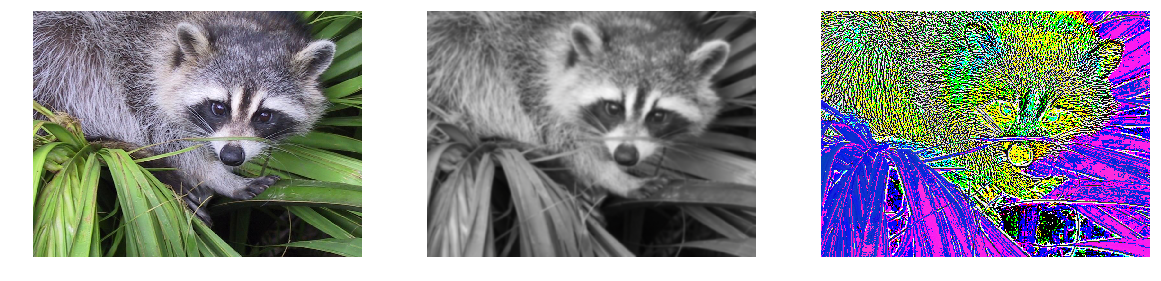

In [170]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(image, cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(filtered, cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(image - filtered, cmap=plt.cm.gray)
plt.axis('off')

In [172]:
def rgb2gray(image):
    return np.dot(image[...,:3], [0.299, 0.587, 0.114])

In [173]:
image_gray = rgb2gray(image)

In [175]:
lbp = feature.local_binary_pattern(image_gray, numPoints,
            radius, method="uniform")


(-0.5, 1023.5, 767.5, -0.5)

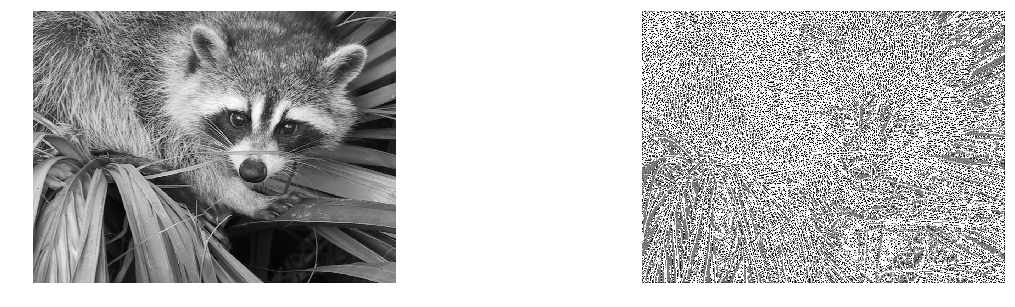

In [176]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(image_gray, cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbp, cmap=plt.cm.gray)
plt.axis('off')

In [44]:
path = 'data/flowers/rose/99383371_37a5ac12a3_n.jpg'

In [45]:
with open(path, 'rb') as f:
    flbase = os.path.basename(path)

    with Image.open(f) as img:
         image = img.convert('RGB')

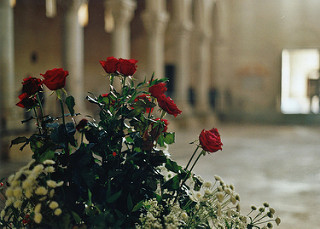

In [46]:
image

In [47]:
image = np.array(image)        
img = np.dot(image[...,:3], [0.299, 0.587, 0.114]).astype(int)

In [48]:
img=img/255.

In [50]:
img.min()

0.0